In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 83% 124M/149M [00:00<00:00, 175MB/s]
100% 149M/149M [00:00<00:00, 171MB/s]


In [6]:
!unzip -q /content/brain-tumor-mri-dataset.zip -d /content/

In [7]:
!pip install tensorflow

In [8]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import roc_curve

from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, LSTM, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [9]:
train_path ="/content/Training"

In [10]:
test_path = "/content/Testing"

In [11]:
classes = sorted(os.listdir(train_path))
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [12]:
def to_frame(path):
    class_types = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            class_name = os.path.splitext(file)[0]
            class_types.append(class_name)
    image_classes = pd.Series(class_types, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [13]:
train_df = to_frame(train_path)

In [14]:
test_df = to_frame(test_path)

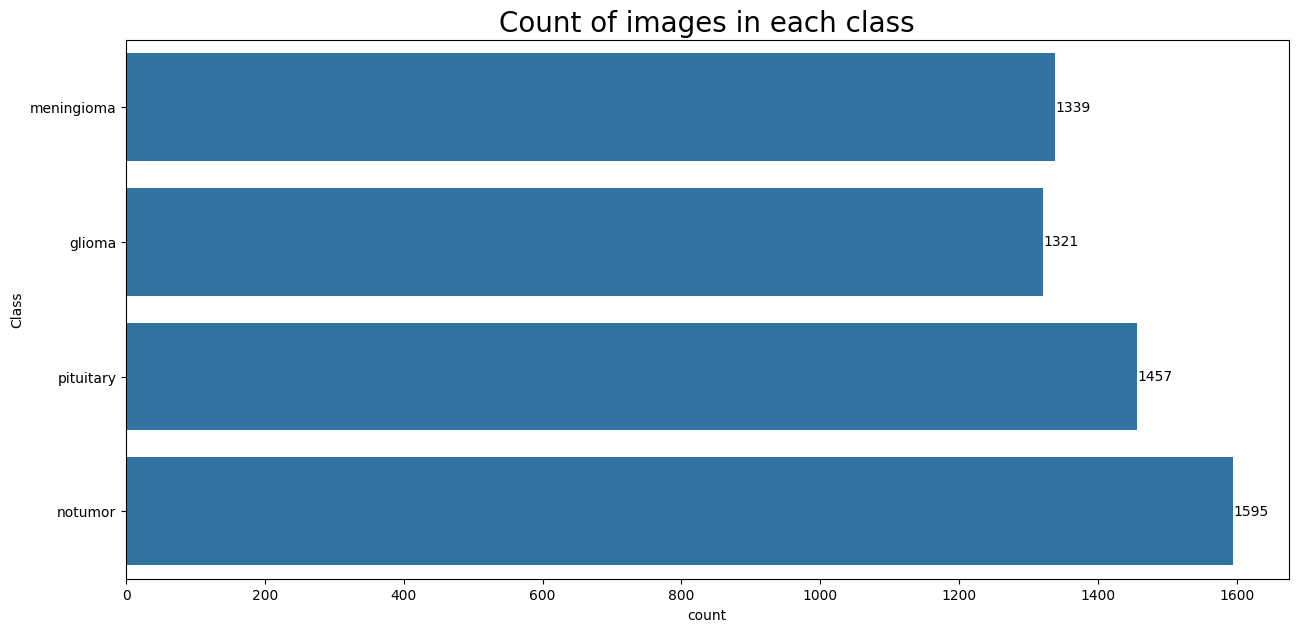

In [15]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Class'])
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [16]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])

In [17]:
valid_df

,Class Path,Class
592,/content/Testing/glioma/Te-gl_0139.jpg,glioma
18,/content/Testing/meningioma/Te-me_0221.jpg,meningioma
667,/content/Testing/pituitary/Te-pi_0216.jpg,pituitary
73,/content/Testing/meningioma/Te-me_0277.jpg,meningioma
415,/content/Testing/glioma/Te-gl_0226.jpg,glioma
...,...,...
365,/content/Testing/glioma/Te-gl_0268.jpg,glioma
1160,/content/Testing/notumor/Te-no_0218.jpg,notumor
579,/content/Testing/glioma/Te-gl_0147.jpg,glioma
194,/content/Testing/meningioma/Te-me_0067.jpg,meningioma


In [18]:
batch_size = 32
img_size = (256, 256)

_gen = ImageDataGenerator(rescale=1.0/255, brightness_range=(0.8, 1.2),
                          rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                          shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                          fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1.0/255)

train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


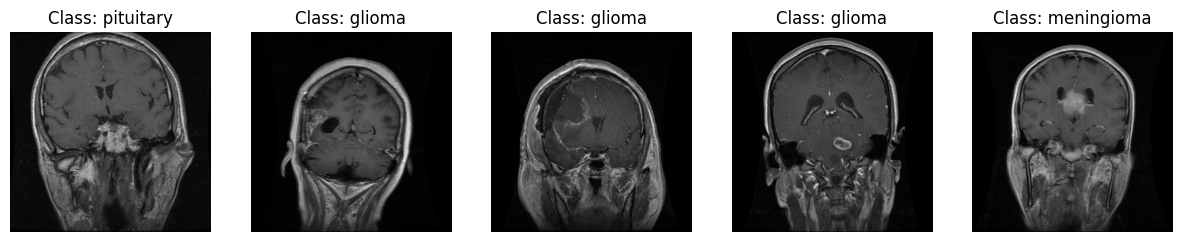

In [19]:
def display_random_images(df, num_images=5):
    random_indices = random.sample(range(len(df)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image_path = df.loc[idx, 'Class Path']
        class_name = df.loc[idx, 'Class']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    plt.show()

display_random_images(train_df)

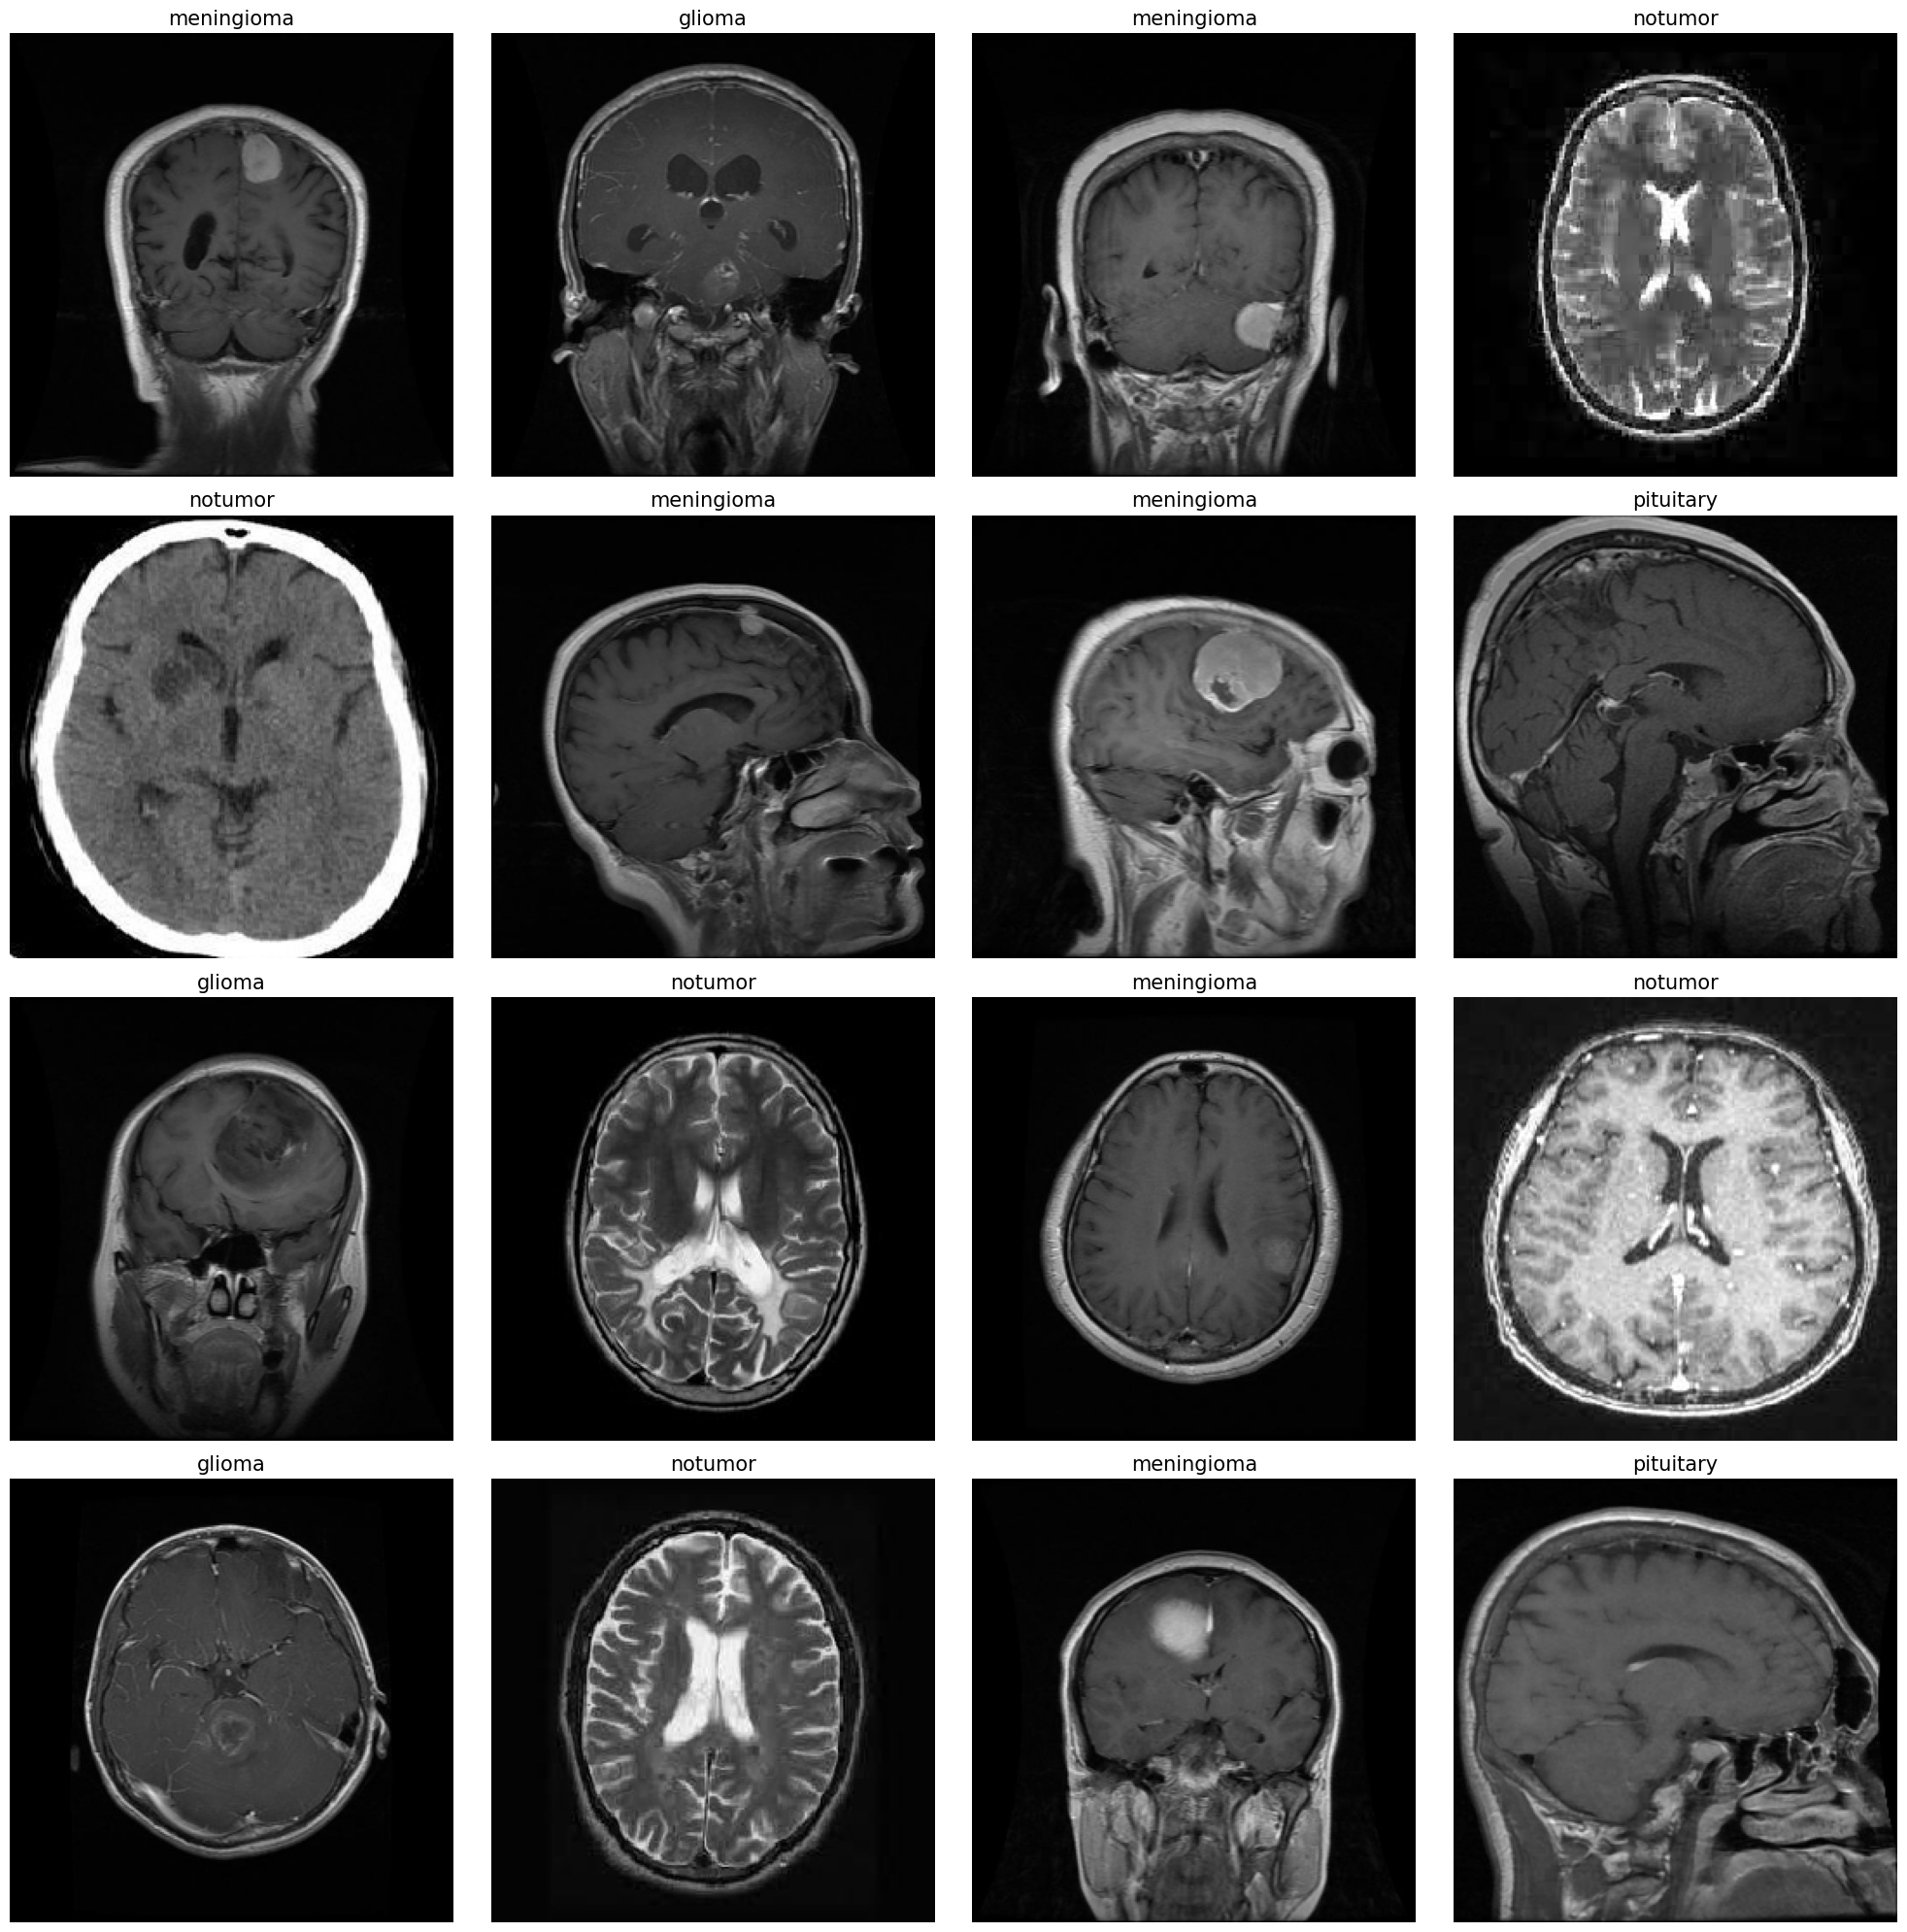

In [20]:
# class_dict = train_gen.class_indices
# classes = list(class_dict.keys())
# images, labels = next(test_gen)

# plt.figure(figsize=(20, 20))

# for i, (image, label) in enumerate(zip(images, labels)):
#     plt.subplot(4,4, i + 1)
#     plt.imshow(image)
#     class_name = classes[np.argmax(label)]
#     plt.title(class_name, color='k', fontsize=15)

# plt.show()

class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Get a batch of images and labels from the test generator
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

# Display a maximum of 16 images
num_images_to_display = min(len(images), 16)

for i in range(num_images_to_display):
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots
    plt.imshow(images[i])  # Display the image
    class_name = classes[np.argmax(labels[i])]  # Get the class name for the label
    plt.title(class_name, color='k', fontsize=15)  # Set the title with the class name
    plt.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()


In [21]:
img_shape = (256, 256, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=img_shape)

model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Flatten(),
    Dense(512, activation='relu'),

    Dropout(rate=0.3),
    Dense(128, activation='relu'),

    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)          0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                         

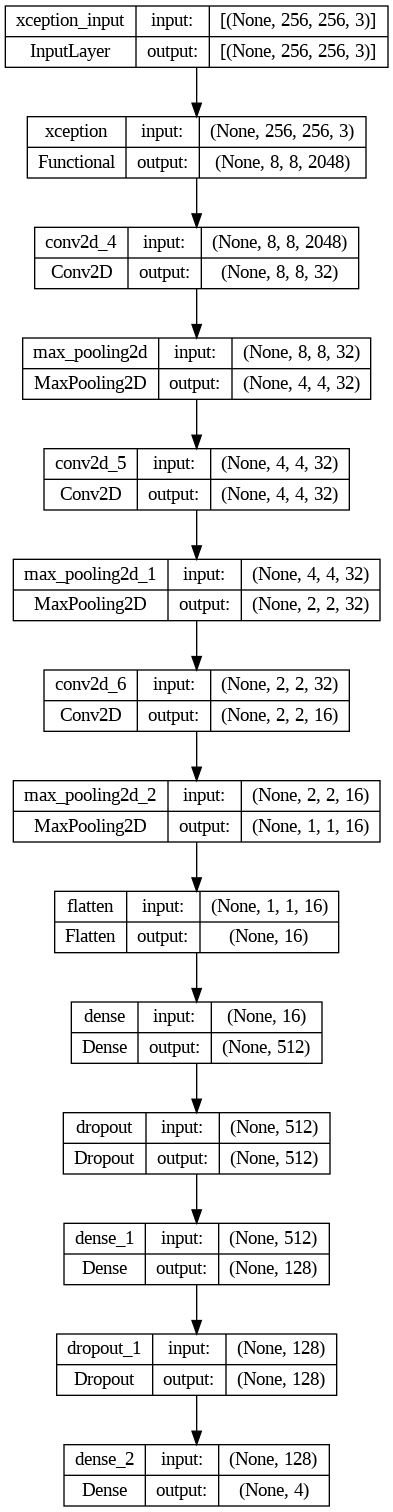

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
hist = model.fit(train_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
179/179 [==============================] - 233s 1s/step - loss: 0.5999 - accuracy: 0.7773 - precision: 0.9269 - recall: 0.6261 - val_loss: 0.7895 - val_accuracy: 0.8626 - val_precision: 0.8658 - val_recall: 0.8473
Epoch 2/5
179/179 [==============================] - 168s 940ms/step - loss: 0.1815 - accuracy: 0.9461 - precision: 0.9562 - recall: 0.9335 - val_loss: 0.2675 - val_accuracy: 0.9008 - val_precision: 0.9193 - val_recall: 0.8870
Epoch 3/5
179/179 [==============================] - 174s 970ms/step - loss: 0.1044 - accuracy: 0.9695 - precision: 0.9764 - recall: 0.9617 - val_loss: 0.1095 - val_accuracy: 0.9634 - val_precision: 0.9751 - val_recall: 0.9557
Epoch 4/5
179/179 [==============================] - 169s 946ms/step - loss: 0.0750 - accuracy: 0.9779 - precision: 0.9827 - recall: 0.9748 - val_loss: 0.0823 - val_accuracy: 0.9802 - val_precision: 0.9816 - val_recall: 0.9756
Epoch 5/5
179/179 [==============================] - 168s 934ms/step - loss: 0.0551 - accuracy:

In [24]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

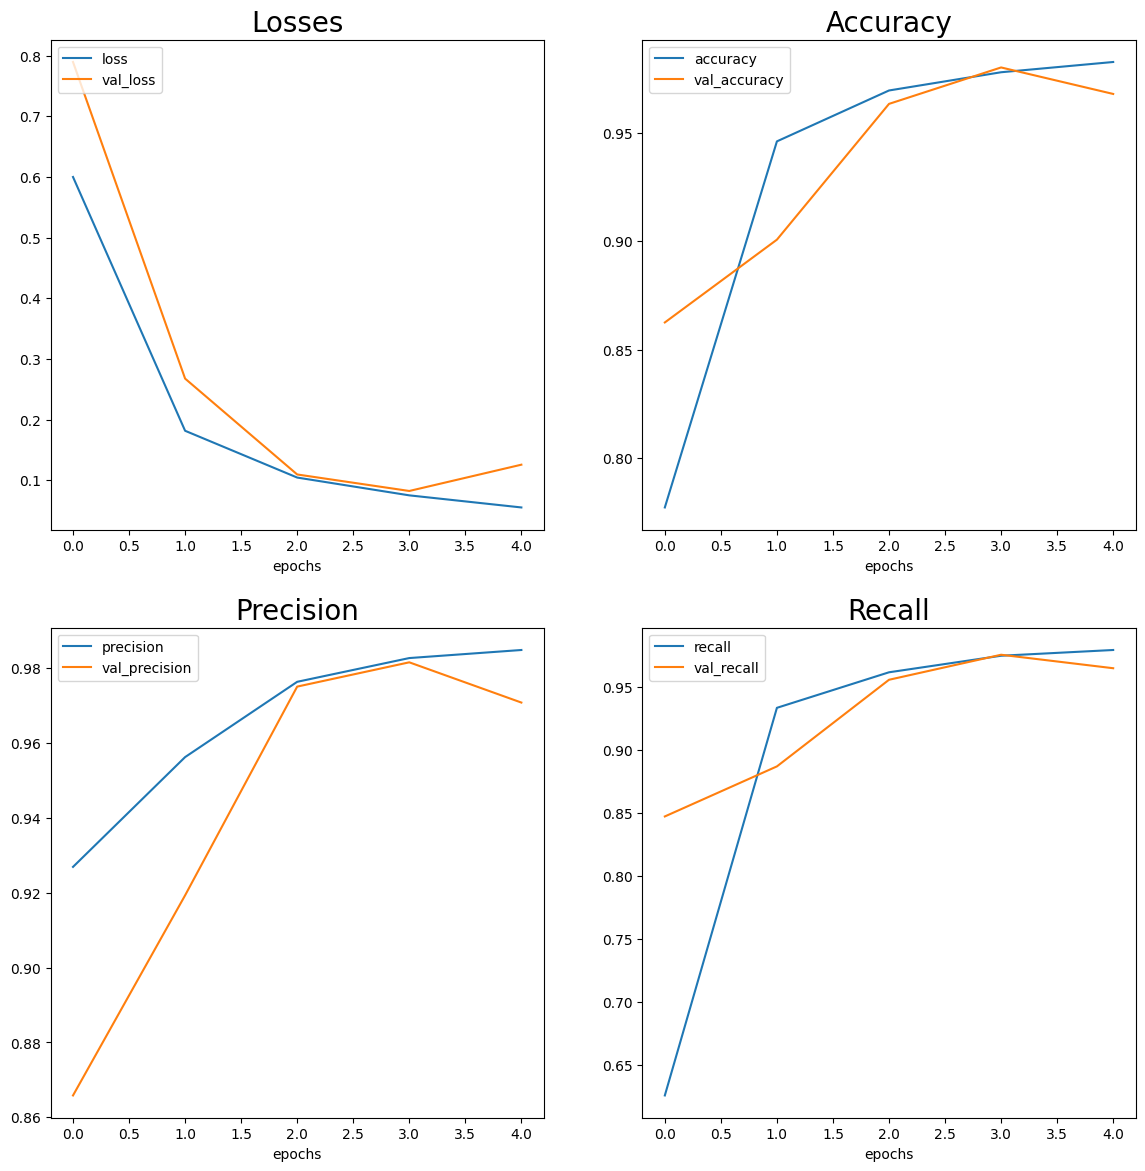

In [25]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

In [26]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

21/21 [==============================] - 3s 157ms/step - loss: 0.1251 - accuracy: 0.9665 - precision: 0.9709 - recall: 0.9649
Train Loss:  0.044130247086286545
Train Accuracy:  0.9872198700904846
--------------------
Validation Loss:  0.11279132962226868
Validation Accuracy:  0.970992386341095
--------------------
Test Loss:  0.12512928247451782
Test Accuracy:  0.9664633870124817


In [27]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       150
  meningioma       0.95      0.95      0.95       153
     notumor       1.00      0.98      0.99       203
   pituitary       0.91      0.99      0.95       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.96       656
weighted avg       0.97      0.97      0.97       656



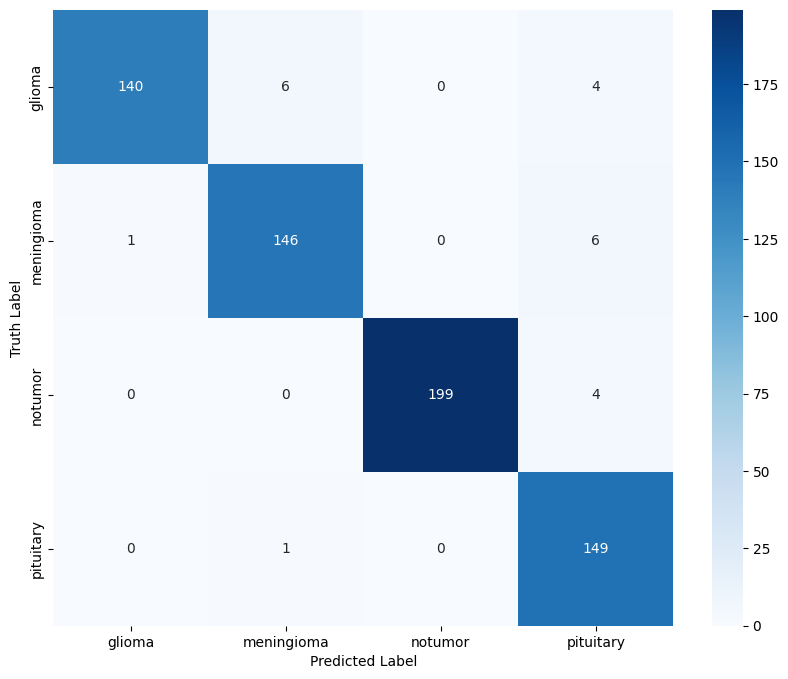

In [28]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = classes
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

1/1 [==============================] - 0s 80ms/step
Predicted Label: pituitary and Actual Label: pituitary


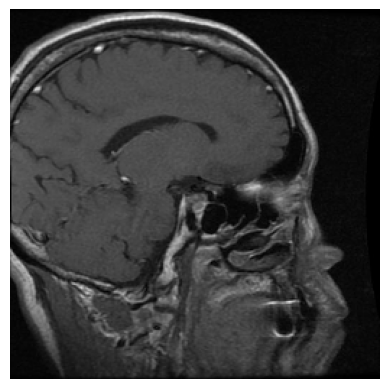

1/1 [==============================] - 0s 49ms/step
Predicted Label: meningioma and Actual Label: meningioma


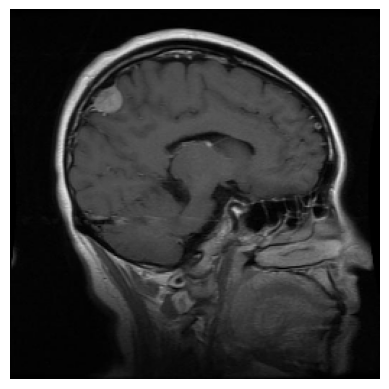

1/1 [==============================] - 0s 108ms/step
Predicted Label: pituitary and Actual Label: pituitary


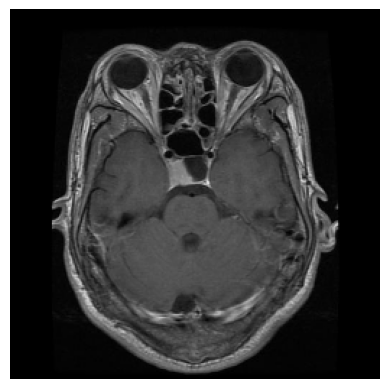

1/1 [==============================] - 0s 94ms/step
Predicted Label: notumor and Actual Label: notumor


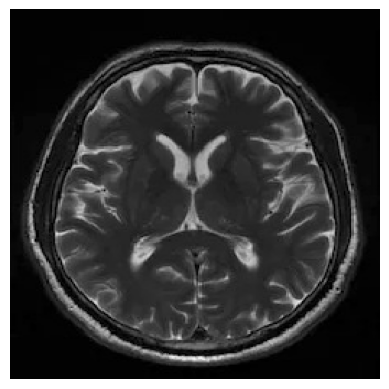

1/1 [==============================] - 0s 65ms/step
Predicted Label: notumor and Actual Label: notumor


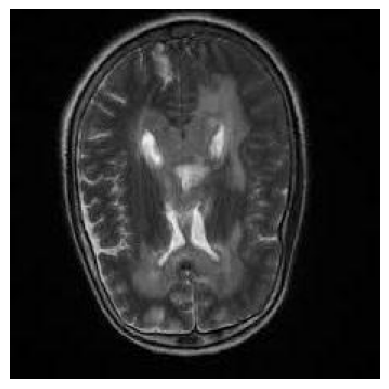

1/1 [==============================] - 0s 53ms/step
Predicted Label: glioma and Actual Label: glioma


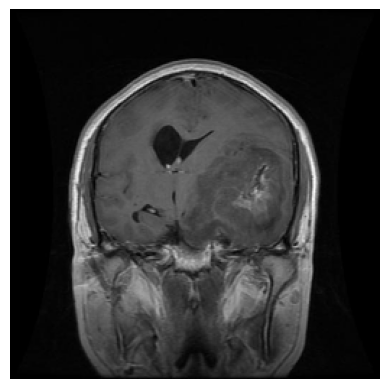

1/1 [==============================] - 0s 82ms/step
Predicted Label: notumor and Actual Label: notumor


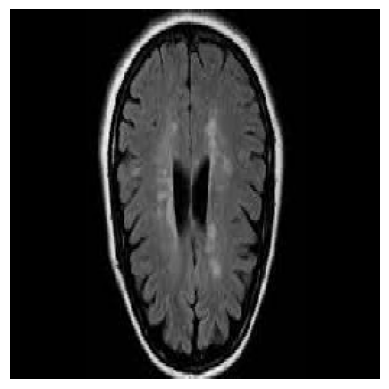

1/1 [==============================] - 0s 76ms/step
Predicted Label: pituitary and Actual Label: pituitary


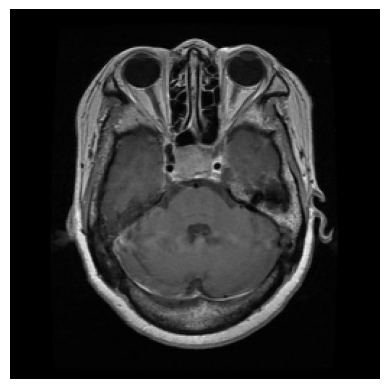

1/1 [==============================] - 0s 86ms/step
Predicted Label: pituitary and Actual Label: pituitary


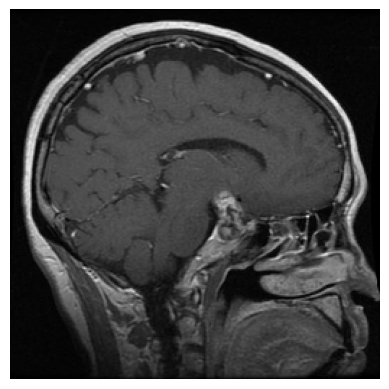

1/1 [==============================] - 0s 64ms/step
Predicted Label: glioma and Actual Label: glioma


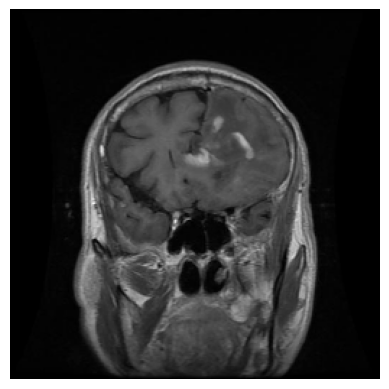

In [30]:
images_test, labels_test = next(iter(test_gen))

for i in range(10):
    plt.imshow(images_test[i])
    plt.axis('off')

    prediction = np.argmax(model.predict(images_test[i][np.newaxis, ...]))
    actual_label = np.argmax(labels_test[i])  # Convert one-hot to index

    print(f"Predicted Label: {classes[prediction]} and Actual Label: {classes[actual_label]}")
    plt.show()